In [1]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from keras import metrics
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense

Mounted at /content/drive


In [2]:
def processData(data):
    X = data.iloc[:,:].values
    X = np.delete(X, 0, 1)
    X = np.delete(X, 1, 1)
    for i in range(len(X)):
        if(isinstance(X[i][5],str) or isinstance(X[i][7],str)):
            X[i] = np.zeros((1, X.shape[1]))
            # print("se" , end = " ")
    return X


In [3]:
def getData(filename):
    data = pd.read_csv(filename,delimiter=',', engine='python')
    X = processData(data)
    return X

In [4]:
def makeDataPoint(patientNo):
    file1 = (patientNo)+"_CLNF_AUs.txt"
    file2 = (patientNo)+"_CLNF_features.txt"
    file3 = (patientNo)+"_CLNF_features3D.txt"
    file4 = (patientNo)+"_CLNF_gaze.txt"
    file5 = (patientNo)+"_CLNF_hog.txt"
    file6 = (patientNo)+"_CLNF_pose.txt"

    X1 = getData(file1)
    X2 = getData(file2)
    X3 = getData(file3)
    X4 = getData(file4)
    X6 = getData(file6)

    X = np.concatenate((X1, X2, X3, X4, X6), 1)
    return X

In [5]:
def scale_down(X):
  X_new = []
  size = 2
  for i in range(int(X.shape[0]/size)):
    cur_row = X[i*size]
    for j in range(1,size):
      if(i+j < X.shape[0]):
        cur_row += X[i+j]
    cur_row = cur_row/size
    X_new.append(cur_row)
  X_new = np.array(X_new)
  return X_new

In [6]:
def decrease_size(X):
  size = 10000
  if(X.shape[0] < size):
    dif = size - X.shape[0]
    temp = np.zeros((dif,X.shape[1]))
    X = np.concatenate((X,temp),axis = 0)
  elif(X.shape[0] > size):
    X = X[:10000, :]
  return X

In [7]:
def makeDataset(location, folder):
    file  = np.array(pd.read_csv(location,delimiter=',',encoding='utf-8'))[:, 0:2]
    X_temp = []
    Y_temp = []
    for i in range(len(file)):
      patientID = (str(int(file[i][0])))
      string = '/content/drive/MyDrive/Dataset_Extracted/' + folder +"/"+ patientID
      XT = makeDataPoint(string)
      XT = scale_down(XT)
      XT = decrease_size(XT)
      X_temp.append(XT)
      Y_temp.append(int(file[i][1]))
    Y_temp = np.asarray(Y_temp)
    return X_temp, Y_temp

In [8]:
class CNN_Video:
  def __init__(self):
    # Initialising the CNN
    classifier = Sequential()
    # Step 1 - Convolution
    classifier.add(Conv1D(300, 3, input_shape = (10000, 388), activation = 'relu'))
    # Step 2 - Pooling
    classifier.add(MaxPooling1D(pool_size = 2))
    classifier.add(Conv1D(150, 3, activation = 'relu'))
    classifier.add(MaxPooling1D(pool_size = 2))
    # Adding a second convolutional layer
    classifier.add(Conv1D(75, 3, activation = 'relu'))
    classifier.add(MaxPooling1D(pool_size = 2))
    classifier.add(Conv1D(32, 3, activation = 'relu'))
    classifier.add(MaxPooling1D(pool_size = 2))
    # Step 3 - Flattening
    classifier.add(Flatten())
    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))

  # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    class_weight = { 0: 0.3, 1:0.7}
    self.classifier = classifier

  def fitModel(self, XtrainTotal, YtrainTotal, epoch = 5):
    return self.classifier.fit(XtrainTotal, YtrainTotal, epochs=epoch)

  def predictModel(self, X_test):
    return self.classifier.predict(np.asarray(X_test))

In [9]:
# # Get Dataset
X_train, Y_train = makeDataset(r'/content/drive/MyDrive/Dataset/train_split_Depression_AVEC2017.csv', 'train_data')
X_dev, Y_dev = makeDataset(r'/content/drive/MyDrive/Dataset/dev_split_Depression_AVEC2017.csv', 'dev_data')
X_test, Y_test = makeDataset(r'/content/drive/MyDrive/Dataset/full_test_split.csv', 'test_data')
YtrainTotal = np.concatenate((Y_train, Y_dev))
XtrainTotal = X_train + X_dev
XtrainTotal = np.asarray(XtrainTotal, dtype=np.float32)




In [10]:
# # Run Model On Test Set
model = CNN_Video()
model.fitModel(XtrainTotal, YtrainTotal, 50)


Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 73006.6875
Epoch 2/50
5/5 [==============================] - 8s 1s/step - loss: 2860.9243
Epoch 3/50
5/5 [==============================] - 8s 2s/step - loss: 6621.9888
Epoch 4/50
5/5 [==============================] - 8s 1s/step - loss: 5082.1748
Epoch 5/50
5/5 [==============================] - 8s 1s/step - loss: 1338.2510
Epoch 6/50
5/5 [==============================] - 7s 1s/step - loss: 5825.8818
Epoch 7/50
5/5 [==============================] - 7s 1s/step - loss: 2465.3557
Epoch 8/50
5/5 [==============================] - 8s 1s/step - loss: 1764.3112
Epoch 9/50
5/5 [==============================] - 8s 1s/step - loss: 1421.2383
Epoch 10/50
5/5 [==============================] - 8s 1s/step - loss: 2879.5481
Epoch 11/50
5/5 [==============================] - 8s 1s/step - loss: 2075.5586
Epoch 12/50
5/5 [==============================] - 7s 1s/step - loss: 137.1892
Epoch 13/50
5/5 [==============================]

In [11]:
# Convert the list to a NumPy array
X_test_np = np.array(X_test)

# Check the data type of the NumPy array
data_type = X_test_np.dtype

print("Data type of the NumPy array:", data_type)



Data type of the NumPy array: object


In [12]:
# Convert the NumPy array to float32 if not already
X_test_np = X_test_np.astype(np.float32)

In [15]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Convert NumPy arrays to TensorFlow tensors
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Now use the input tensor for prediction
Y_pred= model.predictModel(X_test_tf)

# Threshold the predicted probabilities to get binary predictions
threshold = 0.5
Y_pred_binary = (Y_pred >= threshold).astype(int)


2/2 [==============================] - 1s 220ms/step


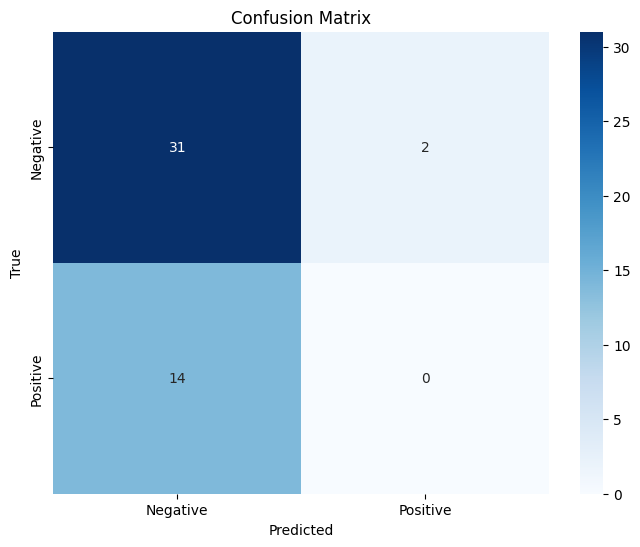

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_binary)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Print classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79        33
           1       0.00      0.00      0.00        14

    accuracy                           0.66        47
   macro avg       0.34      0.47      0.40        47
weighted avg       0.48      0.66      0.56        47

